<a href="https://colab.research.google.com/github/shivpatri/hierachical-graph-learning/blob/main/graphlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction: Problem Statement

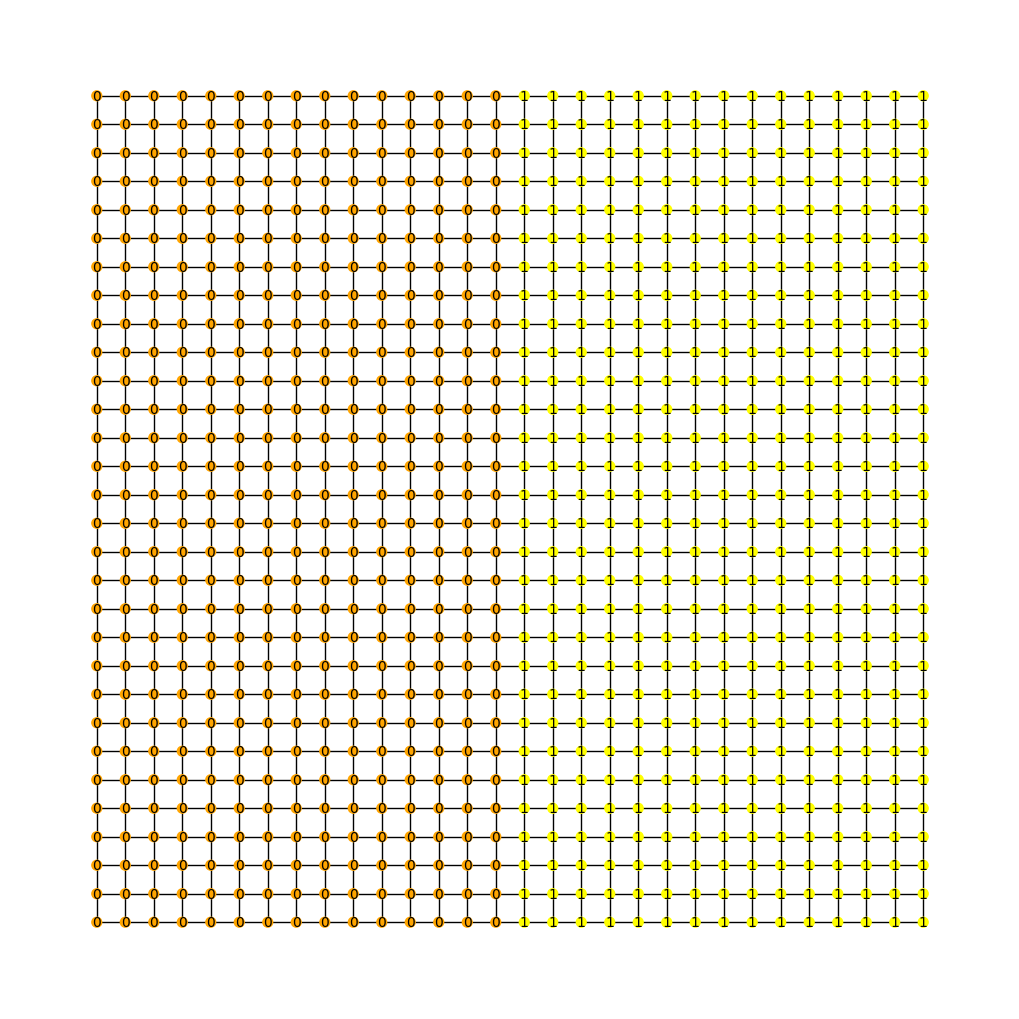

In [31]:
# prompt: Generate a grid graph of size 10 x 10 using networkx and display it

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import SpectralEmbedding

# Create a grid graph
G = nx.grid_2d_graph(30, 30)

# Define the seed nodes
seed_nodes = [(5, 5), (25, 25)]

# Add seed nodes to the graph
G.add_nodes_from(seed_nodes)

# Create a dictionary for node positions
pos = {(x,y):(y,-x) for x,y in G.nodes()}

# Define Node Labels
node_labels = dict(((i, j), 0 if j < 15 else 1) for i, j in G.nodes())

# Define node colors based on node labels
node_colors = ['orange' if label == 0 else 'yellow' for label in node_labels.values()]

# Adjust figure size
plt.figure(figsize=(10, 10))

# Draw the graph
nx.draw(G, pos=pos, labels = node_labels, with_labels=True, node_size=50, node_color=node_colors, font_size=10)

# Display the graph
plt.show()


In [32]:
# prompt: Use spectral clustering to get node embeddings, apply k-means to then cluster the embeddings and display the clusters

# Get the adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Apply spectral clustering
spectral_embedding = SpectralEmbedding(n_components=10, affinity='precomputed')
embeddings = spectral_embedding.fit_transform(adj_matrix)
embeddings.shape


(900, 10)

In [33]:
# prompt: implement k means from scratch where a few centroids are fixed

import numpy as np

def kmeans_with_fixed_centroids(data, k, fixed_centroids, max_iters=100, tol=1e-4):
  """
  K-means clustering with fixed centroids.

  Args:
    data: The data points.
    k: The number of clusters.
    fixed_centroids: A list of fixed centroids.
    max_iters: The maximum number of iterations.
    tol: The tolerance for convergence.

  Returns:
    cluster_assignments: An array of cluster assignments for each data point.
    centroids: The final centroids.
  """

  # Initialize centroids
  n_fixed_centroids = len(fixed_centroids)
  n_data_points = data.shape[0]
  centroids = np.array(fixed_centroids)

  # Initialize remaining centroids randomly
  if k > n_fixed_centroids:
    remaining_centroids = data[np.random.choice(n_data_points, size=k - n_fixed_centroids, replace=False)]
    centroids = np.concatenate((centroids, remaining_centroids), axis=0)

  # Initialize cluster assignments
  cluster_assignments = np.zeros(n_data_points, dtype=int)

  # Iterate until convergence
  for _ in range(max_iters):
    prev_cluster_assignments = cluster_assignments.copy()

    # Assign data points to clusters
    for i in range(n_data_points):
      distances = np.linalg.norm(data[i] - centroids, axis=1)
      cluster_assignments[i] = np.argmin(distances)

    # Update centroids
    for j in range(n_fixed_centroids, k):
      cluster_points = data[cluster_assignments == j]
      if len(cluster_points) > 0:
        centroids[j] = np.mean(cluster_points, axis=0)

    # Check for convergence
    if np.sum(np.abs(cluster_assignments - prev_cluster_assignments)) < tol:
      break

  return cluster_assignments, centroids


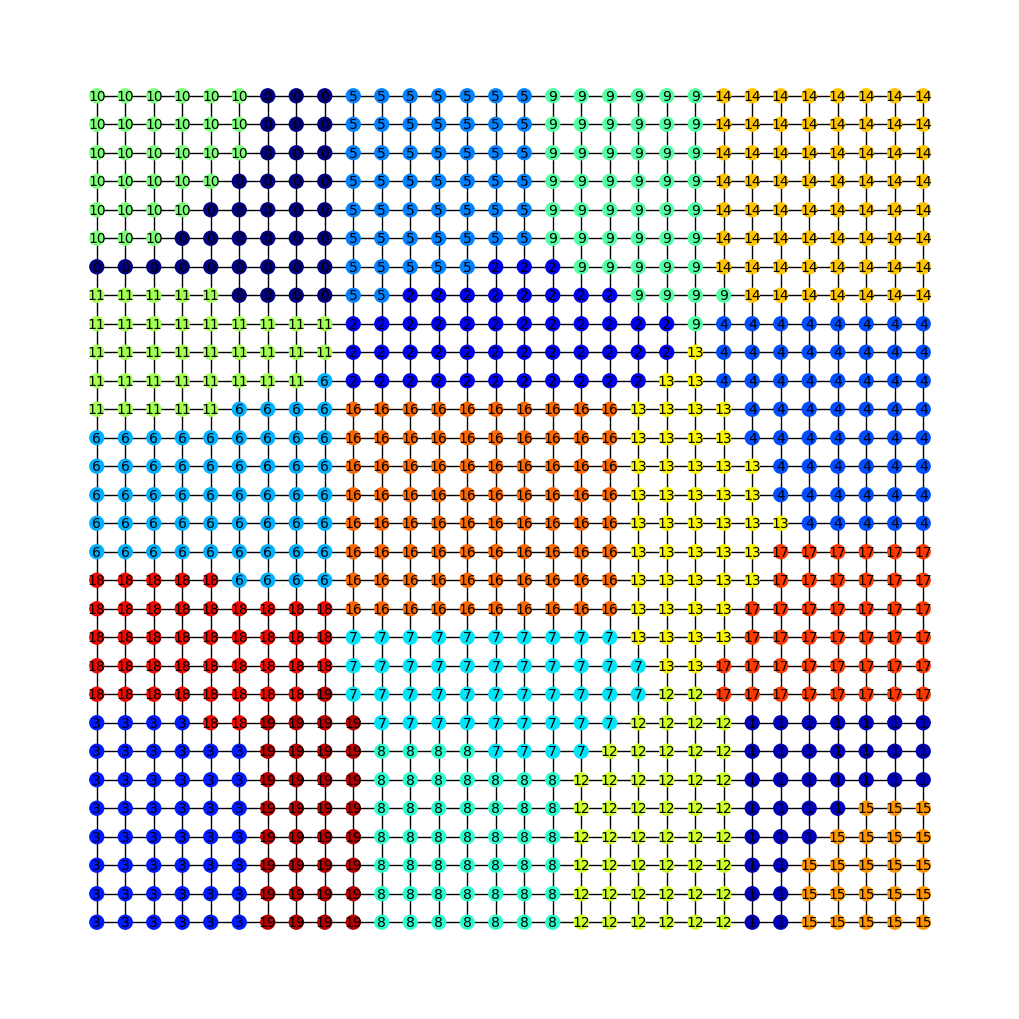

In [34]:
# prompt: run k_means_with_fixed_centroids with seed nodes as fixed centroids, embed the seed node before kmeans

# Get the adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Apply spectral clustering
spectral_embedding = SpectralEmbedding(n_components=5, affinity='precomputed')
embeddings = spectral_embedding.fit_transform(adj_matrix)

# Get the embeddings of the seed nodes
seed_node_embeddings = [embeddings[list(G.nodes()).index(node)] for node in seed_nodes]

# Apply k-means clustering with fixed centroids
cluster_assignments, centroids = kmeans_with_fixed_centroids(embeddings, 20, seed_node_embeddings)

# Assign cluster labels to nodes
cluster_labels = dict(zip(G.nodes(), cluster_assignments))

# Define node colors based on cluster labels
node_colors = [plt.cm.jet(i / 20) for i in cluster_assignments]

# Adjust figure size
plt.figure(figsize=(10, 10))

# Draw the graph with cluster labels
nx.draw(G, pos=pos, labels = cluster_labels, with_labels=True, node_size=100, node_color=node_colors, font_size=10)

# Display the graph
plt.show()


In [35]:
# prompt: positions of the nodes closest to the centroids

# Find the indices of the nodes closest to each centroid
closest_node_indices = []
for centroid in centroids:
  distances = np.linalg.norm(embeddings - centroid, axis=1)
  closest_node_index = np.argmin(distances)
  closest_node_indices.append(closest_node_index)

# Get the positions of the closest nodes
closest_node_positions = [list(G.nodes())[i] for i in closest_node_indices]

print("Positions of the nodes closest to the centroids:", closest_node_positions)


Positions of the nodes closest to the centroids: [(5, 5), (25, 25), (8, 14), (25, 3), (11, 25), (3, 12), (14, 5), (21, 14), (26, 13), (4, 19), (3, 3), (9, 4), (25, 20), (15, 21), (4, 25), (27, 27), (15, 13), (19, 25), (19, 4), (25, 8)]


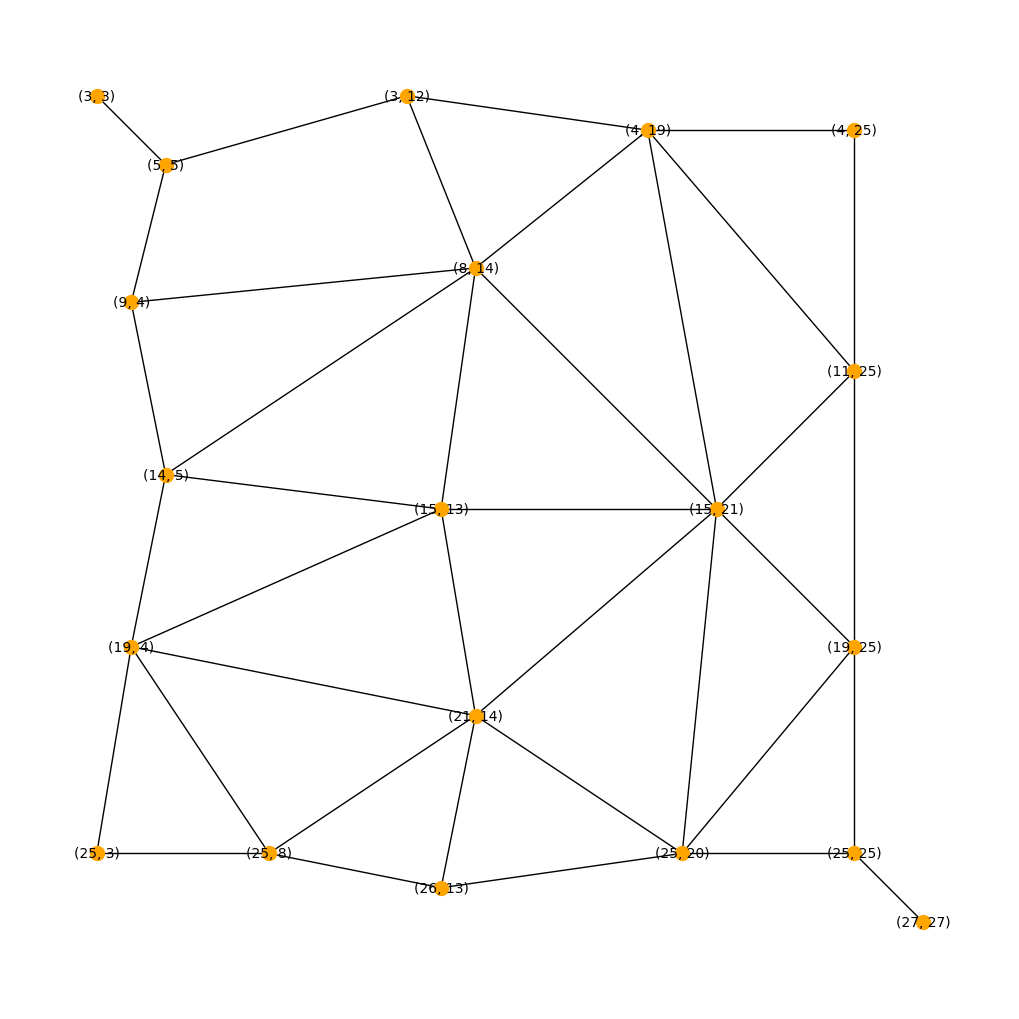

In [36]:
# prompt: reduce the graph to it's cluster centroids and edges if clusters are connected

# Create a new graph with the cluster centroids as nodes
H = nx.Graph()

# Add the nodes corresponding to the cluster centroids
H.add_nodes_from(closest_node_positions)

# Check for connections between clusters
for i in range(len(closest_node_positions)):
  for j in range(i + 1, len(closest_node_positions)):
    # Get the nodes in cluster i and cluster j
    nodes_i = [node for node, label in cluster_labels.items() if label == i]
    nodes_j = [node for node, label in cluster_labels.items() if label == j]

    # Check if there is an edge between any node in cluster i and any node in cluster j
    for node_i in nodes_i:
      for node_j in nodes_j:
        if G.has_edge(node_i, node_j):
          # Add an edge between the centroids of cluster i and cluster j
          H.add_edge(closest_node_positions[i], closest_node_positions[j])

# Define the positions for the new graph
pos_H = {node: pos[node] for node in H.nodes()}

# Adjust figure size
plt.figure(figsize=(10, 10))
# Draw the reduced graph
nx.draw(H, pos=pos_H, with_labels=True, node_size=100, node_color='orange', font_size=10)

plt.show()


In [37]:
import networkx as nx
import random

def s2_algorithm_with_hints(graph, budget, hint_set):
    """
    Implements the S2 active learning algorithm with an initial hint set.

    Parameters:
    - graph: A NetworkX graph where each node has an unknown binary label.
    - budget: The maximum number of queries allowed.
    - hint_set: A dictionary where keys are node IDs and values are their known labels.

    Returns:
    - L: A list of queried nodes and their labels.
    """
    L = list(hint_set.items())  # Start with the hint set as initially labeled vertices

    while (len(L) < budget) and nx.is_connected(graph):
        # Remove edges between oppositely labeled nodes
        for u, v in list(graph.edges):
            if any(l[0] == u for l in L) and any(l[0] == v for l in L):
                if get_label(u, L) != get_label(v, L):
                    graph.remove_edge(u, v)

        # Find the shortest path between oppositely labeled nodes
        #oppositely_labeled_pairs = [(u, v) for u, v in L if get_label(u) != get_label(v)]
        oppositely_labeled_pairs = [
            (u[0], v[0]) for u in L for v in L
            if get_label(u[0]) != get_label(v[0])
            and u[0] != v[0]  # Avoid pairing a node with itself
        ]
        if oppositely_labeled_pairs:
            shortest_path = None
            min_length = float('inf')
            for u, v in oppositely_labeled_pairs:
                if nx.has_path(graph, source=u, target=v):
                    path = nx.shortest_path(graph, source=u, target=v)
                    if len(path) < min_length:
                        shortest_path = path
                        min_length = len(path)
                else:
                    break

            if shortest_path and len(shortest_path) > 1:
                mid_point = shortest_path[len(shortest_path) // 2]
                if mid_point not in [l[0] for l in L]:
                    # Query the midpoint's label
                    label_mid = get_label(mid_point)
                    L.append((mid_point, label_mid))
        else:
            # Randomly choose an unlabeled vertex
            break
    return L, graph

def get_label(node, labeled_set=None):
    """
    Simulates querying a node's label or retrieves it from a pre-labeled set.

    Parameters:
    - node: The node to query.
    - labeled_set: A list of tuples representing already labeled nodes.

    Returns:
    - int: The label of the node (-1 or +1).

    Note: This function should be replaced with actual logic to get a node's label.
    """
    # Replace this with actual logic to fetch a node's label
    return node_labels[node]

In [38]:
# prompt: run s2 on the code above

# Assuming you have the graph G and the node_labels dictionary defined as before

# Define the budget for the S2 algorithm
budget = 15

# Define an initial hint set (e.g., labels of the seed nodes)
hint_set = {seed_nodes[0]: node_labels[seed_nodes[0]], seed_nodes[1]: node_labels[seed_nodes[1]]}

# Run the S2 algorithm with the initial hint set
labeled_nodes, graph_to_display = s2_algorithm_with_hints(H.copy(), budget, hint_set)

# Print the labeled nodes and their labels
for node, label in labeled_nodes:
    print(f"Node: {node}, Label: {label}")

# You can further analyze the labeled nodes and their labels to evaluate the performance of the S2 algorithm.


Node: (5, 5), Label: 0
Node: (25, 25), Label: 1
Node: (15, 21), Label: 1
Node: (8, 14), Label: 0
Node: (4, 19), Label: 1
Node: (3, 12), Label: 0
Node: (15, 13), Label: 0
Node: (21, 14), Label: 0
Node: (25, 20), Label: 1
Node: (26, 13), Label: 0


Results:

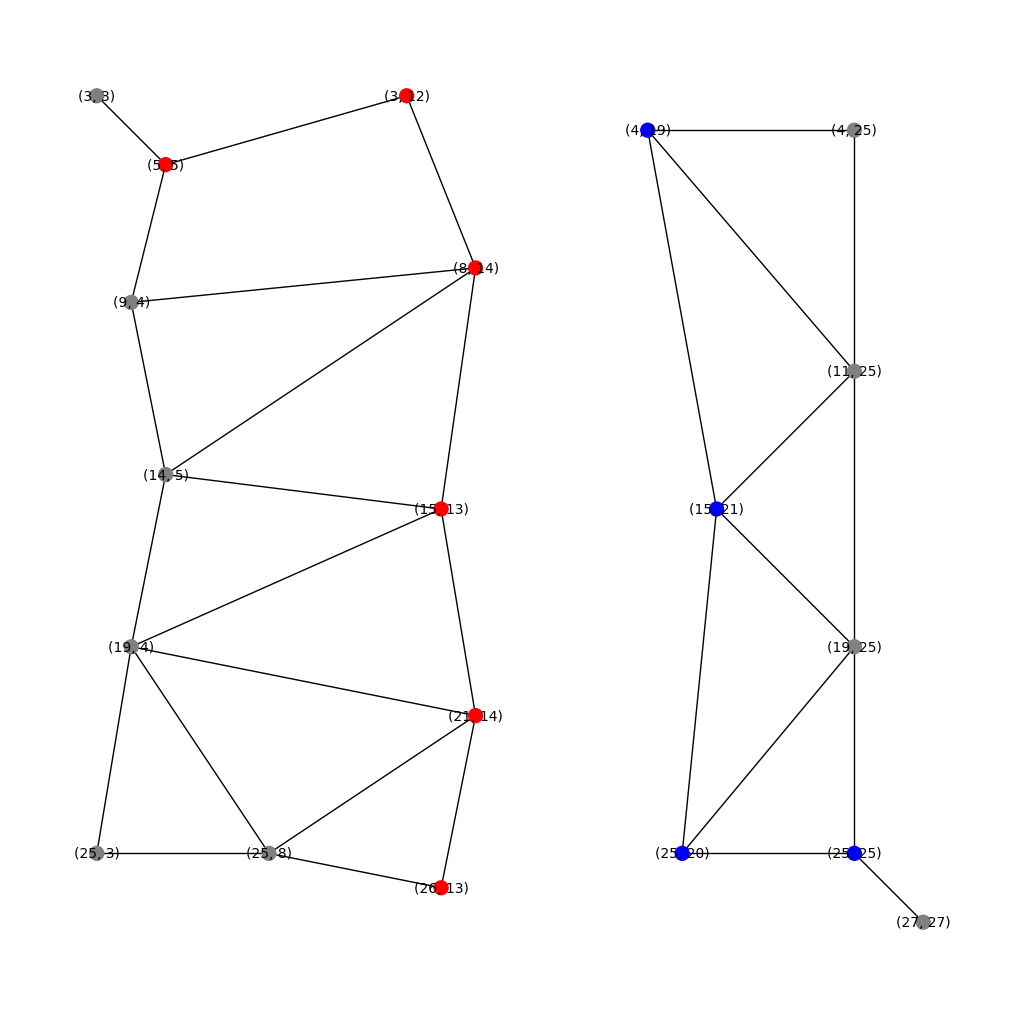

In [39]:
# prompt: display the graph with queried labels and remaining edges

# Create a copy of the graph to avoid modifying the original
#graph_to_display = H.copy()

# Define node colors based on the labels obtained from the S2 algorithm
node_colors_displayed = ['red' if (node in [l[0] for l in labeled_nodes] and get_label(node, labeled_nodes) == 0)
                        else 'blue' if (node in [l[0] for l in labeled_nodes] and get_label(node, labeled_nodes) == 1)
                        else 'gray' for node in graph_to_display.nodes()]

# Adjust figure size
plt.figure(figsize=(10, 10))

# Draw the graph with queried labels
nx.draw(graph_to_display, pos=pos_H, with_labels=True, node_size=100, node_color=node_colors_displayed, font_size=10)

plt.show()


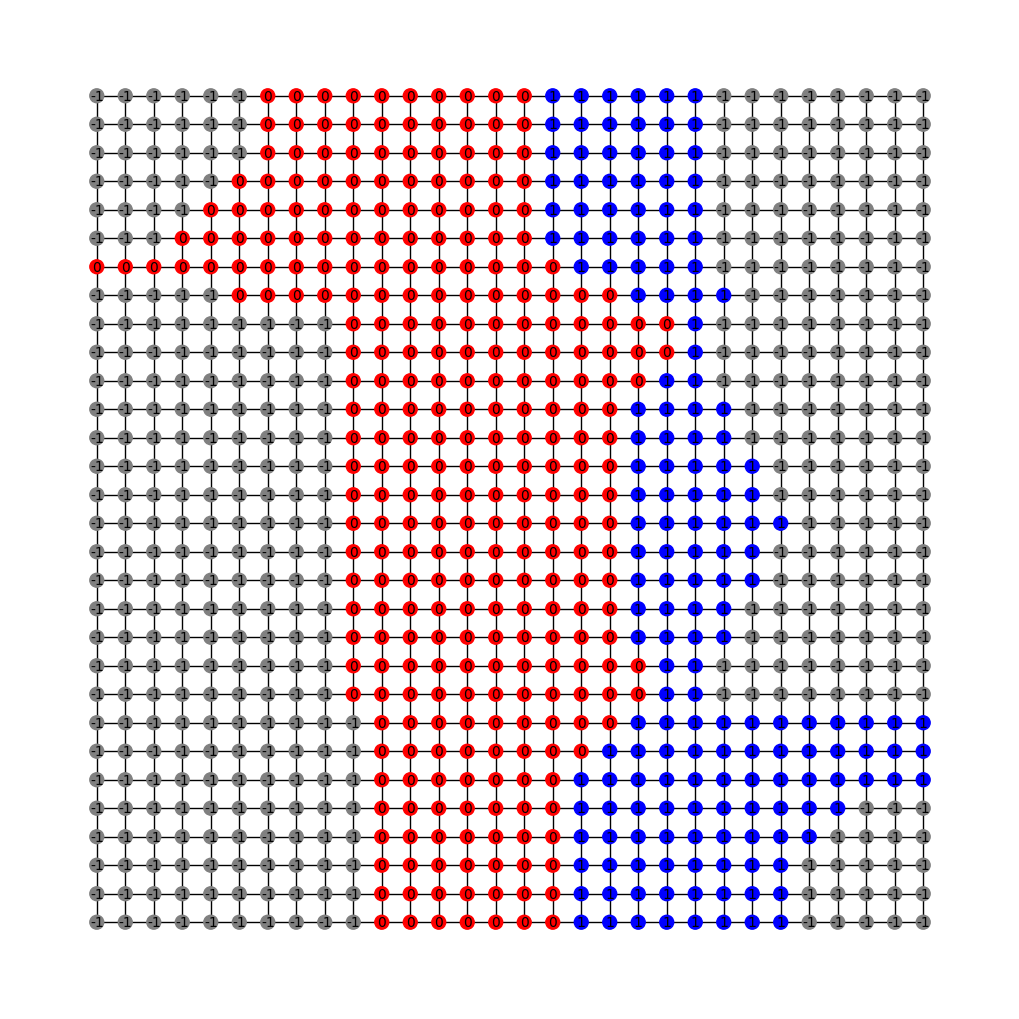

In [40]:
# prompt: assign the newly discovered centroid labels from s2 to all the nodes in the cluster and display on the original graph

# Create a dictionary to map cluster centroids to their labels from S2
centroid_labels = {node: label for node, label in labeled_nodes}

# Create a new dictionary to store the assigned labels for all nodes in the original graph
new_node_labels = {}
for node, cluster_id in cluster_labels.items():
  if list(G.nodes())[closest_node_indices[cluster_id]] in centroid_labels:
    new_node_labels[node] = centroid_labels[list(G.nodes())[closest_node_indices[cluster_id]]]
  else:
    new_node_labels[node] = -1 # Assign -1 if the centroid doesn't have a label yet

# Define node colors based on the new labels
node_colors = ['red' if label == 0 else 'blue' if label == 1 else 'gray' for label in new_node_labels.values()]

# Adjust figure size
plt.figure(figsize=(10, 10))

# Draw the original graph with the assigned labels
nx.draw(G, pos=pos, labels=new_node_labels, with_labels=True, node_size=100, node_color=node_colors, font_size=10)

plt.show()
